In [1]:
import torch

from torchvision.transforms import ToTensor, Compose, Normalize

from data.dataset import get_data

from model.model import YOLONet
from model.train import train
from model.loss import DetectionLoss

DATASET = "../datasets/Human-Fall-Detection"
BATCH_SIZE = 8

SUBSET = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform_data = Compose([ToTensor(), Normalize((0.4379,), (0.3040,))])

data = get_data(DATASET, transform_data, device=device, batch_size=BATCH_SIZE, end=BATCH_SIZE)

train_loader, val_loader, test_loader = list(data["dataloaders"].values())

tensor([[2.0000, 0.2805, 0.7047, 0.2422, 0.5906],
        [2.0000, 0.2969, 0.3063, 0.2617, 0.5070],
        [2.0000, 0.6070, 0.6836, 0.3859, 0.6328]])


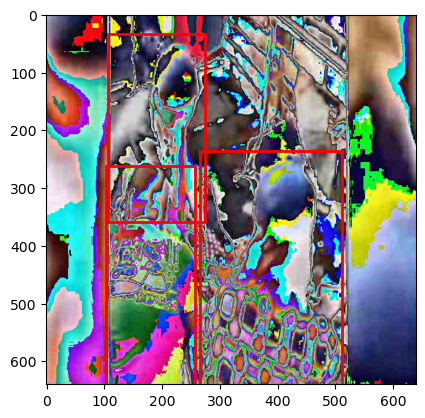

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms

train_dataset = data["datasets"]["train"]

# Get a sample from the dataset
image, label = train_dataset[1]
_, height, width = image.shape
# image = image.permute(2, 0, 1)

# Convert tensor image back to PIL for visualization
image = transforms.ToPILImage()(image)
print(label)

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

for l in label:
    class_label = l[0]
    bbox_labels = l[1:]
    
    # Extract normalized bounding box coordinates
    x_min_norm, y_min_norm, box_width_norm, box_height_norm = bbox_labels
    
    # Scale normalized coordinates to image dimensions
    box_width = box_width_norm * width
    box_height = box_height_norm * height
    x_min = x_min_norm * width - box_width/2
    y_min = y_min_norm * height - box_height/2
    
    # Create rectangle patch
    rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=2, edgecolor='r', facecolor='none')
    
    # Add rectangle to plot
    ax.add_patch(rect)

plt.show()

In [3]:
train_sample = next(iter(train_loader))

In [4]:
train_sample[0].shape, train_sample[1].shape

(torch.Size([8, 3, 640, 640]), torch.Size([29, 6]))

In [5]:
with torch.device(device):
  model = YOLONet(ch=(64,32,32))
  model.load_state_dict(torch.load("model_e4.pt"))
  criterion = DetectionLoss(model.head)

In [6]:
images, labels = next(iter(train_loader))
display(images.device, next(model.parameters()).device)

prev = None
for p in model.parameters():
  if p.device != prev:
    print(p.device)
    prev = p.device


device(type='cuda', index=0)

device(type='cuda', index=0)

cuda:0


In [7]:
model.eval()
preds = model(images)
loss = criterion(preds, labels)
loss

c:\Users\yapzh\miniconda3\envs\dlenv\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(tensor(87.2289, device='cuda:0', grad_fn=<MulBackward0>),
 tensor([3.3408, 3.9488, 3.6140], device='cuda:0'))

In [8]:
with torch.device(device):
  new_model = YOLONet(ch=(64,32,32))

preds = new_model(images)
loss = criterion(preds, labels)
loss

(tensor(106.6099, device='cuda:0', grad_fn=<MulBackward0>),
 tensor([3.5089, 5.5455, 4.2718], device='cuda:0'))